### Sử dụng thuật toán Moving Average để xử lý dữ liệu nhiễu

Thuật toán Moving Average có nhiều biến thể để phục vụ xử lý dữ liệu nhiễu, trong có có 3 thuật toán mà em sẽ trình bày dưới đây:
- Simple Moving Average (SMA)
- Weighted Moving Average (WMA)
- Expoential Moving Average (EMA)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [2]:
df = pd.read_csv("data/measData_ver2.csv")
df_ground_truth = pd.read_csv('data/groundtruthData_ver2.csv') # Lấy dữ liệu trong thực tế để đối chiếu

print("Các trường thuộc tính của dữ liệu measData:")
print(df.columns)

print()
print("Các trường thuộc tính của dữ liệu groundtruthData:")
print(df_ground_truth.columns)

print()
print("Năm dòng đầu tiên của bộ dữ liệu measData:")
print(df.head())

print()
print("Năm dòng đầu tiên của bộ dữ liệu groundtruthData:")
print(df_ground_truth.head())

Các trường thuộc tính của dữ liệu measData:
Index(['timeSeries', 'Azimuth (rad)', 'Range (km)', 'x-axis', 'y-axis'], dtype='object')

Các trường thuộc tính của dữ liệu groundtruthData:
Index(['timeSeries', 'Azimuth (rad)', 'Range (km)', 'Speed (km/s)',
       'Heading (rad)', 'x-axis', 'y-axis'],
      dtype='object')

Năm dòng đầu tiên của bộ dữ liệu measData:
   timeSeries  Azimuth (rad)  Range (km)      x-axis     y-axis
0           0       3.663993  200.076675 -173.391253 -99.830602
1          10       3.660711  198.853775 -172.656196 -98.654255
2          20       3.660269  197.974248 -171.935899 -98.141987
3          30       3.649208  196.907839 -172.079002 -95.715799
4          40       3.660394  195.972307 -170.185084 -97.170893

Năm dòng đầu tiên của bộ dữ liệu groundtruthData:
   timeSeries  Azimuth (rad)  Range (km)  Speed (km/s)  Heading (rad)  \
0           0       3.663333  200.000000          0.12       1.049056   
1          10       3.660298  198.963923          0.12 

In [3]:
# Khai báo module đã xây dựng riêng
from private_module.moving_average import simple_moving_average, weighted_moving_average, exponential_moving_average
from private_module.grid_search import find_best_method, find_best_window, mde

x_raw = df['x-axis'].values
y_raw = df['y-axis'].values



x_real = df_ground_truth['x-axis'].values
y_real = df_ground_truth['y-axis'].values

In [4]:
# Compute the MDE
print('Mean Distance Error: ',mde(x_real, x_raw, y_real, y_raw))

Mean Distance Error:  0.8942690597173112


Trước khi tiến hành vào việc xử lý dữ liệu, ta sẽ biểu diễn dữ liệu trong một khoảng nhỏ để thấy được sự biến động trong dữ liệu.

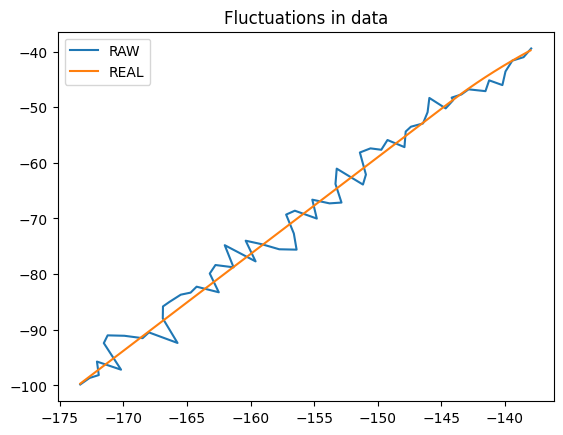

In [5]:
plt.plot(x_raw[:60], y_raw[:60], label='RAW')
plt.plot(x_real[:60], y_real[:60], label='REAL')
plt.legend()
plt.title('Fluctuations in data')
plt.show()

Mọi người có thể nhìn thấy trong hình trên, dữ liệu gốc thu về có sự biến động so với dữ liệu thực tế. Đây là do ảnh hưởng trong quá trình thu nhận dữ liệu, ảnh hưởng khách quan từ yếu tô môi trường. 

Vậy nên trước khi lấy dữ liệu để tính toán, ta cần một bước để xử lý các yếu tố nhiễu này trong dữ liệu.

#### Simple Moving Average 

Thuật toán SMA (Simple Moving Average) sẽ tính giá trị trung bình cho một tập giá trị biết trước. Trong bài toán của chúng ta là tính trung bình của n ngày trước đó

$SMA = \frac{A_1 + A_2 + ... + A_n}{n}$  
Trong đó:  
A: Trung bình của n giá trị trước đó  
n: Số lượng thời gian trước đó.

5 5


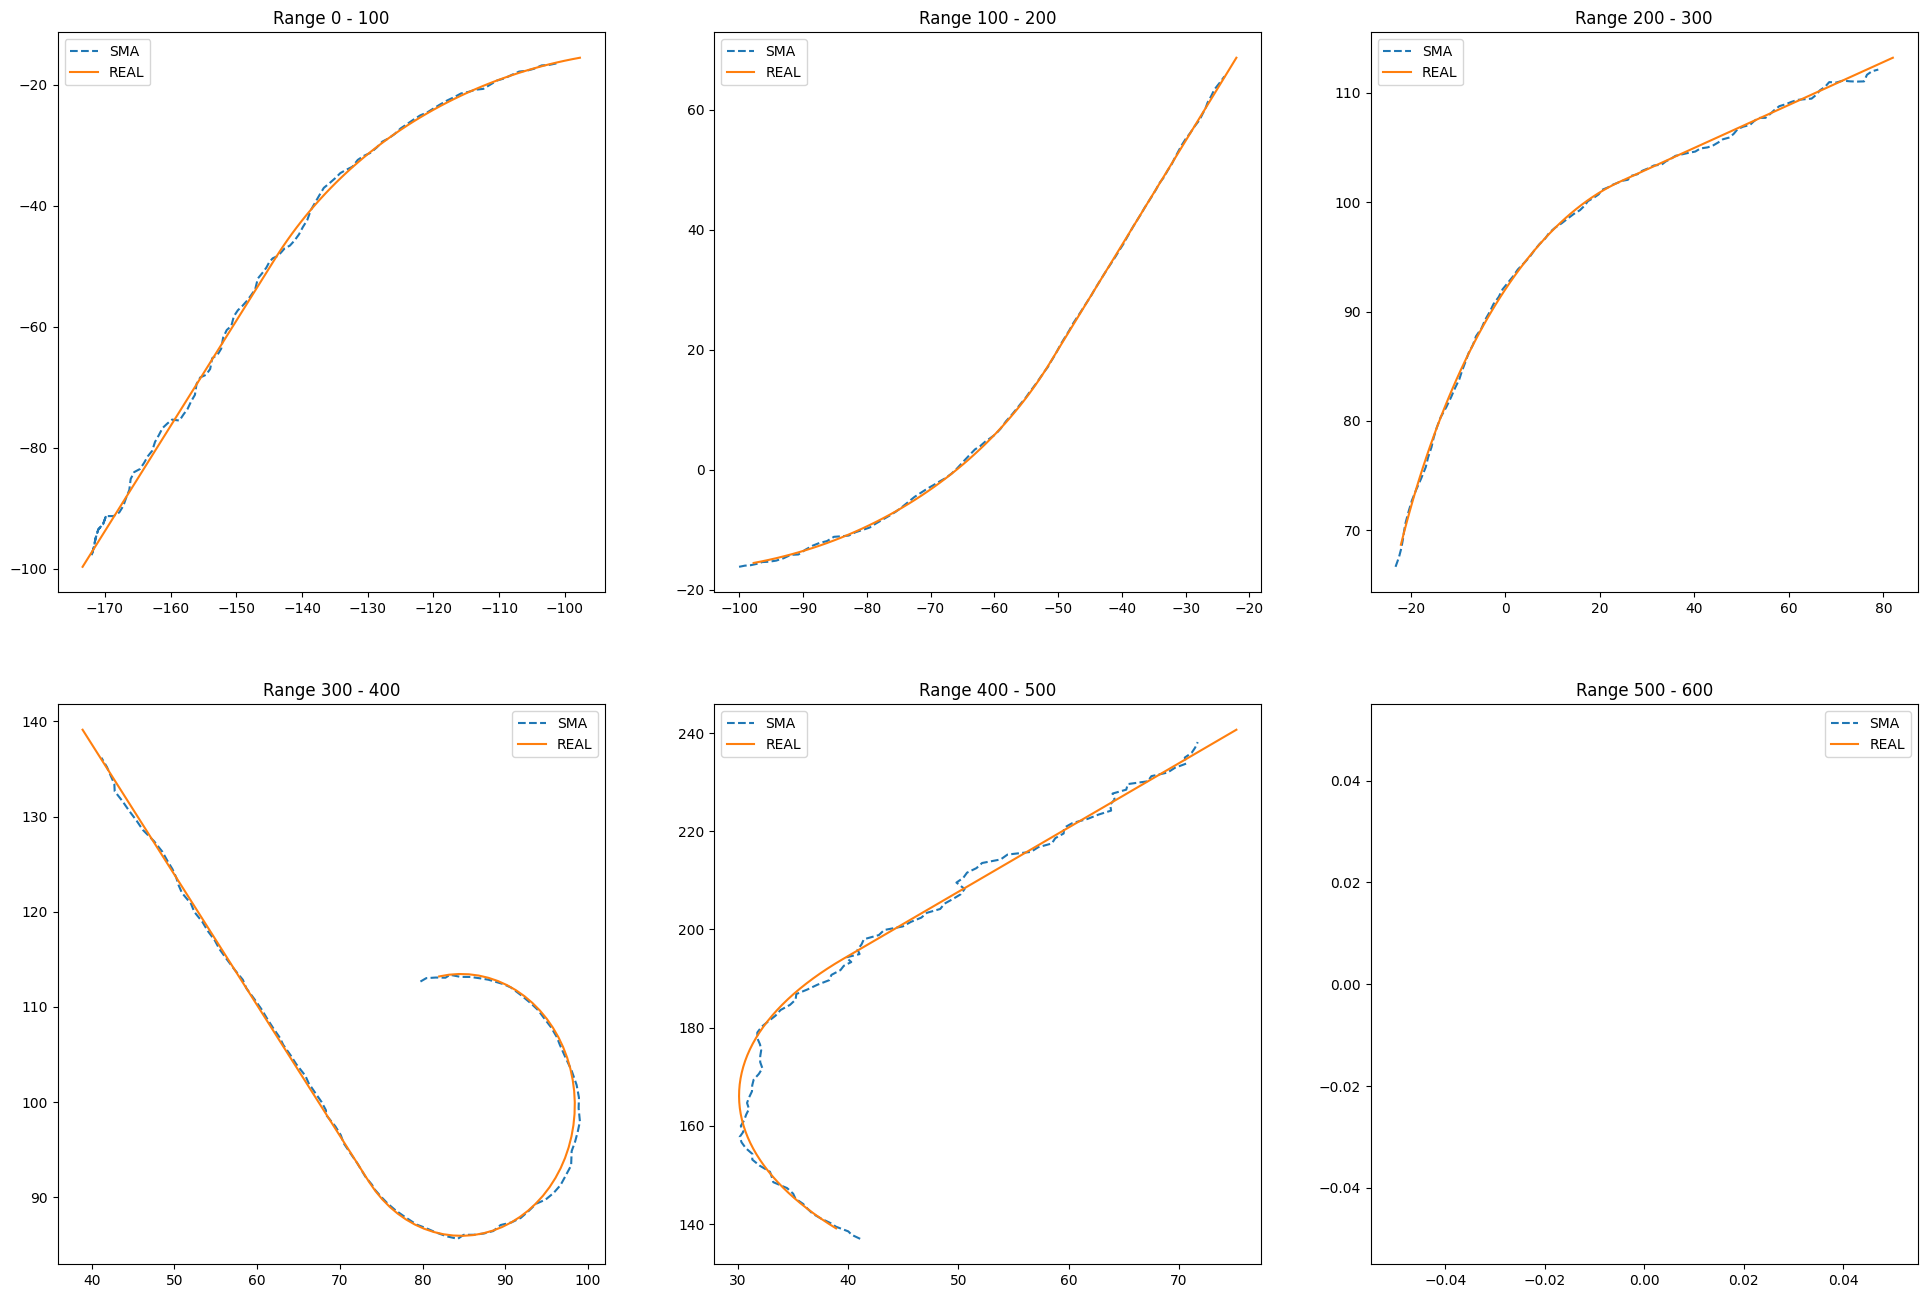

In [6]:

m = n = 5
print(m, n)
# n_window = 2
# Sử dụng module SMA để xử lý dữ liệu nhiễu

# Tính trung bình phương vị
sma_x = simple_moving_average(x_raw, m)
sma_x = np.nan_to_num(sma_x, 0)
# Tính trung bình khoảng cách
sma_y = simple_moving_average(y_raw, n)
sma_y = np.nan_to_num(sma_y, 0)

# Do dữ liệu khi tính trung bình sẽ mất n giá trị đầu, nên ta sẽ lật ngược tập dữ liệu để tính
# Sau đó điền các giá trị bị thiếu bằng giá trị trung bình ngược

# Tính giá trị trung bình phương vị ngược
sma_x_revert = simple_moving_average(np.flip(x_raw, axis=0), m)
sma_x_revert = np.nan_to_num(sma_x_revert, 0)
sma_x[:m] = sma_x_revert[-m:] + sma_x[:m]

# Tính giá trị trung bình khoảng cách ngược
sma_y_revert = simple_moving_average(np.flip(y_raw, axis=0), n)
sma_y_revert = np.nan_to_num(sma_y_revert, 0)
sma_y[:n] = sma_y_revert[-n:] + sma_y[:n]
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(24, 16))

counter = 0
for j in range(2):
    for k in range(3):
            if counter > 5:
                  break
            k_start = counter * 100
            k_end = (counter+1) * 100
            # Hiển thị đồ thị
            axs[j][k].plot(sma_x[k_start:k_end], sma_y[k_start:k_end], linestyle='--', label='SMA')
            axs[j][k].plot(x_real[k_start:k_end], y_real[k_start:k_end], label='REAL')
            axs[j][k].set_title(f'Range {k_start} - {k_end}')
            axs[j][k].legend()
            counter += 1
plt.show()


In [7]:
# Compute the MDE
print('Mean Distance Error: ',mde(x_real, sma_x, y_real, sma_y))

Mean Distance Error:  3.5199181947520417


Sau khi dùng kỹ thuật SMA để xử lý dữ liệu RAW, ta thấy rõ sự thay đổi của dữ liệu. Sữ liệu sau khi được xử lý đã sát hơn với dữ liệu thực tế.

#### Weighted Moving Average

Kỹ thuật WMA (Weighted Moving Average) sẽ gán thêm trọng số vào các điểm dữ liệu trong quá khứ, sau đó tính tổng tập dữ liệu đó.  
  
$WMA = Value_1 * w_1 + Value_2 * w_2 + ... Value_n*w_n$  
  
Trong đó:  
N là thời gian trước đó  

Chú ý: Trọng số được gán cho dữ liệu được tính bằng: $w_i = \frac{i}{\sum_{i=1}^n i}$, với i là ngày thứ mấy trong tập ngày được chọn. (i = 1, 2,..., n)

n_window = 5


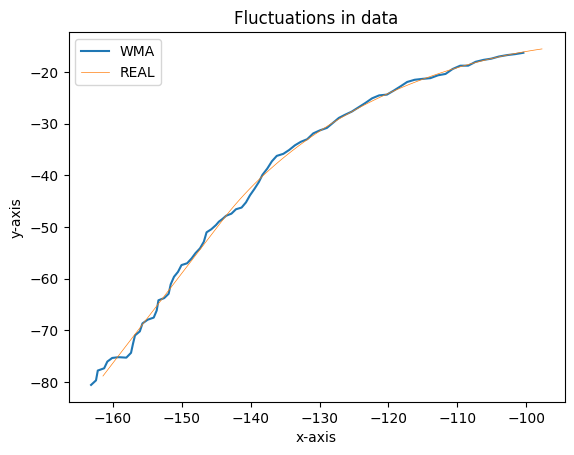

In [8]:
# Sử dụng module wma để xử lý dữ liệu nhiễu
# n_window = find_best_window(x_raw, y_raw, x_real, y_real, f_type='wma')
n_window= 5
print('n_window =',n_window)
# Tính trung bình xuôi
wma_x = weighted_moving_average(x_raw, n_window)
wma_x = np.nan_to_num(wma_x, 0)
wma_y = weighted_moving_average(y_raw, n_window)
wma_y = np.nan_to_num(wma_y, 0)

#Tính trung bình ngược
wma_x_inverse = weighted_moving_average(np.flip(x_raw, axis = 0), n_window)
wma_x_inverse = np.nan_to_num(wma_x_inverse, 0)
wma_y_inverse = weighted_moving_average(np.flip(y_raw,axis=0), n_window)
wma_y_inverse = np.nan_to_num(wma_y_inverse, 0)

#
wma_x[:n_window] = wma_x_inverse[-n_window:] + wma_x[:n_window]
wma_y[:n_window] = wma_y_inverse[-n_window:] + wma_y[:n_window]
plt.plot(wma_x[20:100], wma_y[20:100], label='WMA')
plt.plot(x_real[20:100], y_real[20:100], label='REAL', lw=0.5)
plt.ylabel('y-axis')
plt.xlabel('x-axis')
plt.legend()
plt.title('Fluctuations in data')
plt.show()

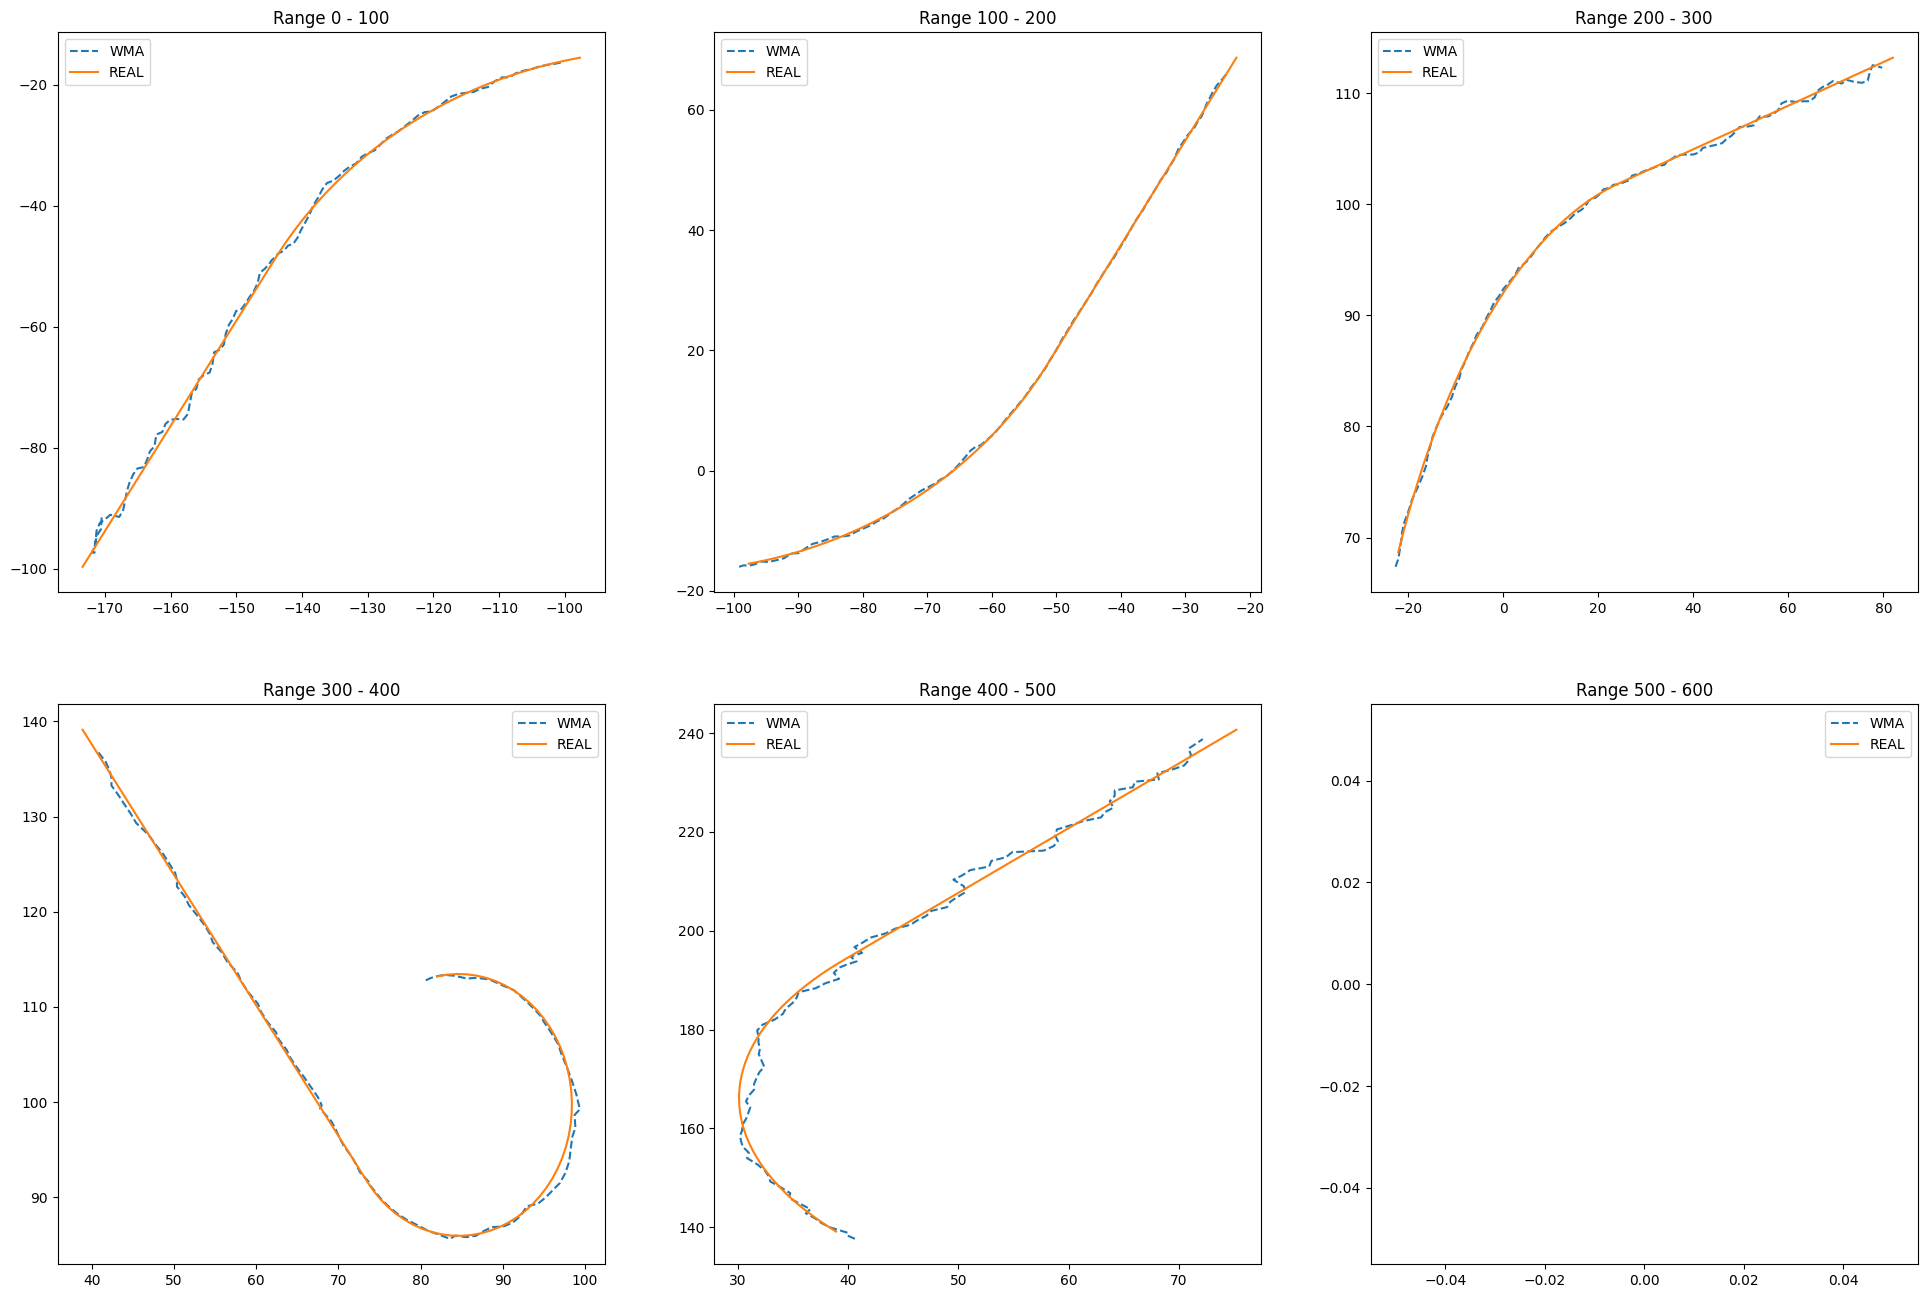

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(24, 16))

counter = 0
for j in range(2):
    for k in range(3):
            if counter > 5:
                  break
            k_start = counter * 100
            k_end = (counter+1) * 100
            # Hiển thị đồ thị
            axs[j][k].plot(wma_x[k_start:k_end], wma_y[k_start:k_end], linestyle='--', label='WMA')
            axs[j][k].plot(x_real[k_start:k_end], y_real[k_start:k_end], label='REAL')
            axs[j][k].set_title(f'Range {k_start} - {k_end}')
            axs[j][k].legend()
            counter += 1
plt.show()

In [10]:
# Compute the MDE
print('Mean Distance Error:', mde(x_real[n_window:], wma_x[n_window:], y_real[n_window:], wma_y[n_window:]))

Mean Distance Error: 2.7412709143798377


#### Exponential Moving Average

Kỹ thuật EMA (Exponential Moving Average) cho trọng số vào các giá trị gần đây trong chuỗi thời gian để làm nó có thêm sự liên quan đến thông tin mới sau đó.   

Thì trước khi tính một EMA, ta cần tính một lượng giá trị SMA nhất định trước đó.  

Sau đó, ta sẽ nhân giá trị SMA đó với trọng số được gọi là "smoothing factor", tính bởi công thức:  

$sf = \frac{s}{d + 1}$  

Và cuối cùng, công thức tính tổng quát của EMA sẽ là:  

$EMA_t = (V_t * sf) + EMA_y * (1 -sf)$   

Trong đó:  
- $EMA_t$ = EMA hiện tại  
- $V_t$ = Giá trị thời điểm hiện tại  
- $EMA_y$ = EMA trước đó  
- d = Số thời gian trước đó
- sf = smoothing factor

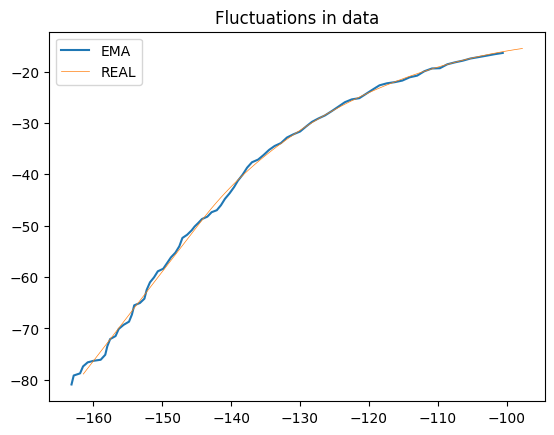

In [11]:
# Sử dụng module ema để xử lý dữ liệu nhiễu
n_window = 6
smooth = 5.5819
ema_x = exponential_moving_average(x_raw, n_window)
ema_y = exponential_moving_average(y_raw, n_window)

plt.plot(ema_x[20:100], ema_y[20:100], label='EMA')
plt.plot(x_real[20:100], y_real[20:100], label='REAL', lw=0.5)
plt.legend()
plt.title('Fluctuations in data')
plt.show()

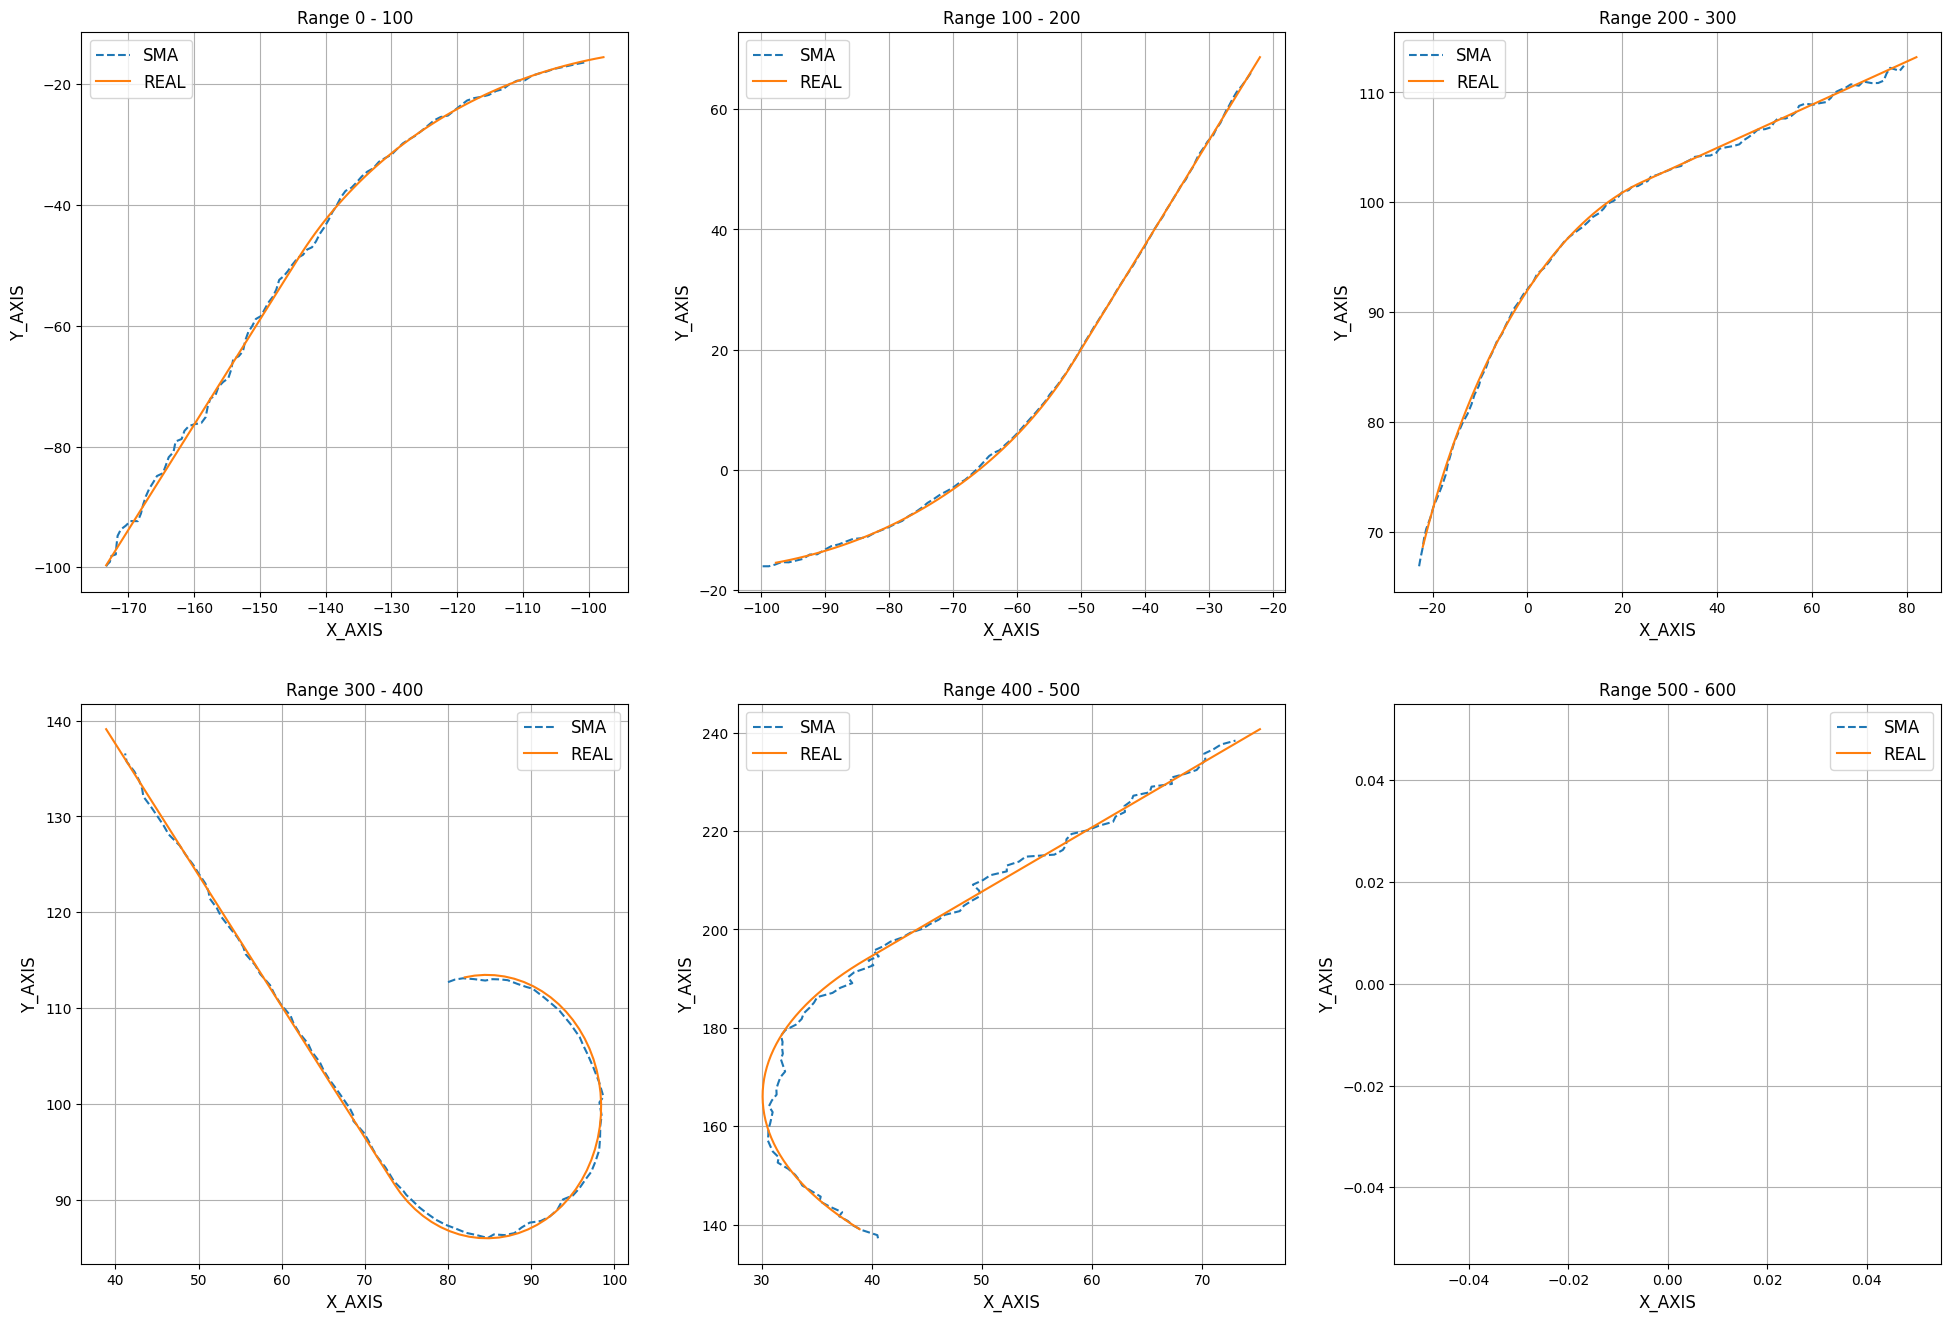

In [12]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(24, 16))

counter = 0
for j in range(2):
    for k in range(3):
            if counter > 5:
                  break
            k_start = counter * 100
            k_end = (counter+1) * 100
            # Hiển thị đồ thị
            axs[j][k].plot(ema_x[k_start:k_end], ema_y[k_start:k_end], linestyle='--', label='SMA')
            axs[j][k].plot(x_real[k_start:k_end], y_real[k_start:k_end], label='REAL')
            axs[j][k].set_title(f'Range {k_start} - {k_end}', fontsize=12)
            axs[j][k].set_xlabel('X_AXIS', fontsize=12)
            axs[j][k].set_ylabel('Y_AXIS', fontsize=12)
            axs[j][k].legend(fontsize=12)
            axs[j][k].grid(True)
            counter += 1
plt.show()

In [13]:
# Compute the MDE
print('Mean Distance Error:', mde(x_real, ema_x, y_real, ema_y))

Mean Distance Error: 2.8929006320651034


In [14]:
# Tối ưu tham số truyền vào

best_smooth = find_best_window(x_raw,y_raw, x_real, y_real)
print('best_smooth_x: ', best_smooth)
# Hàm find_best_smooth trả về một mảng gồm 3 giá trị (smooth, size_window, min_rmse)

# Lấy giá trị cửa sổ
window = best_smooth[0]

# Lấy giá trị smooth factor
smooth = best_smooth[1]


# Gọi hàm exponential_moving_average và truyền vào tham số sau khi được tối ưu
ema_x = exponential_moving_average(x_raw, window, smooth=smooth)
ema_y = exponential_moving_average(y_raw, window, smooth=smooth)

# Tính lại các chỉ số RMSE để đánh giá
# Compute the MDE

print('Mean Distance Error:', mde(x_real, ema_x, y_real, ema_y))


smooth: 5.0 window: 1 mde: 1.481474230131803e+86
smooth: 5.0 window: 2 mde: 2.1466567769294476
smooth: 5.0 window: 3 mde: 1.1849888795734567
smooth: 5.0 window: 4 mde: 0.8942690597173112
smooth: 5.0 window: 5 mde: 0.7922098789095267
smooth: 5.0 window: 6 mde: 0.8146756506920202
smooth: 5.0 window: 7 mde: 0.917538233583571
smooth: 5.0 window: 8 mde: 1.0716097087916914
smooth: 5.0 window: 9 mde: 1.255234378126283
smooth: 5.0 window: 10 mde: 1.4559104680167663
smooth: 5.0 window: 11 mde: 1.6668132091475236
smooth: 5.0 window: 12 mde: 1.88397296896279
smooth: 5.0 window: 13 mde: 2.1050361848534394
smooth: 5.0 window: 14 mde: 2.3285591834758215
smooth: 5.0 window: 15 mde: 2.5536302616951296
smooth: 5.0 window: 16 mde: 2.779657570550072
smooth: 5.0 window: 17 mde: 3.0062450339728457
smooth: 5.0 window: 18 mde: 3.2331191241829322
smooth: 5.0 window: 19 mde: 3.4600851638231633
smooth: 5.0 window: 20 mde: 3.6870007011866184
smooth: 5.0 window: 21 mde: 3.913758861441348
smooth: 5.0 window: 22 md

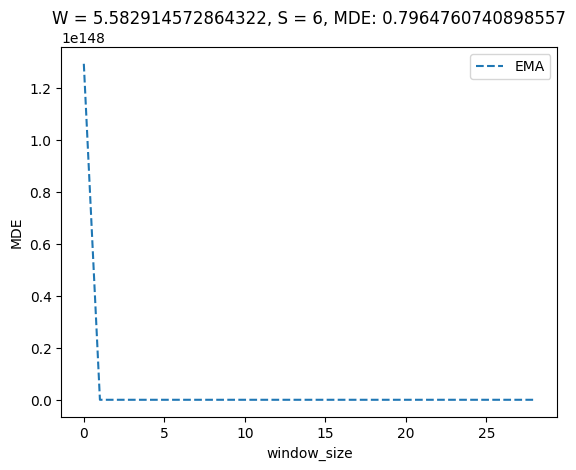

In [15]:
mde_ema = find_best_method([x_raw, y_raw], [x_real,y_real], f_type='ema', smooth=smooth, num_loop=30)
# Plotting the Exponential Moving Average (EMA)
plt.plot(mde_ema, label='EMA', linestyle='--')
plt.xlabel('window_size')
plt.ylabel('MDE')
plt.title(f'W = {window}, S = {smooth}, MDE: {np.min(mde_ema)}')
# Adding a legend to the plot
plt.legend()

# Displaying the plot
plt.show()

Sau khi áp dụng phương pháp trên, ta có được giá trị tối ưu của tham số truyền vào phương phức EMA của từng trường dữ liệu, ta sẽ dùng các giá trị này để đi đánh giá sự phù hợp giữa các mô hình

#### So sánh các kỹ thuật MA (Moving Average)

Sự khác nhau giữa SMA vs WMA:
- SMA chỉ đơn giản là tính trung bình của các điểm dữ liệu trong bộ, và trọng số được gán bằng nhau cho tất cả các quan sát của mẫu.  
- Trong khi đó, WMA sẽ gán một trọng số nhất định cho từng quan sát, với mỗi quan sát gần đây nhất sẽ được gán trọng số lớn hơn các quan sát trước đó. Việc này để thể hiện rõ sự tác động của các quan sát gần đây nhất với giá trị hiện tại


Sự khác nhau giữa SMA và EMA:  
- SMA tương đối chậm trong phản ứng vì nó tính toán trung bình của các giá trị trong một khoảng thời gian dài hơn, và không nhấn mạnh các giá trị gần đây.  
- Trong khi đó EMA phản ứng nhanh với sự thay đổi trong dữ liệu, vì các giá trị gần đây được đánh giá cao hơn trong quá trình tính toán từ đó ảnh hưởng đến kết quả. 

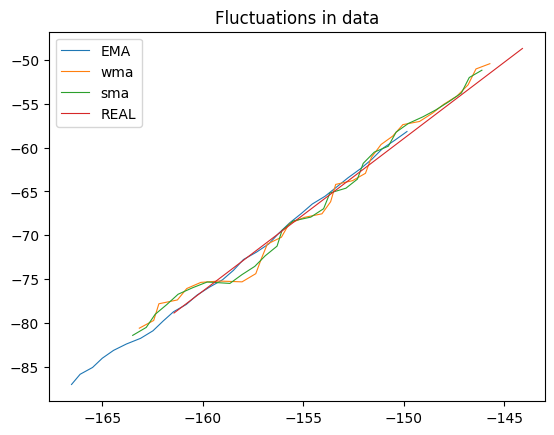

In [16]:
# Sử dụng module ema để xử lý dữ liệu nhiễu
n_window = 20
range_n = 50
ema_x= exponential_moving_average(x_raw, n_window)
ema_y = exponential_moving_average(y_raw, n_window)
plt.plot(ema_x[20:range_n], ema_y[20:range_n], label='EMA', lw=0.8)
plt.plot(wma_x[20:range_n], wma_y[20:range_n], label='wma', lw=0.8)
plt.plot(sma_x[20:range_n], sma_y[20:range_n], label='sma', lw=0.8)
plt.plot(x_real[20:range_n], y_real[20:range_n], label='REAL', lw=0.8)
plt.legend()
plt.title('Fluctuations in data')
plt.show()

In [17]:
mde_sma = find_best_method([x_raw, y_raw], [x_real,y_real], f_type='sma')
mde_wma = find_best_method([x_raw, y_raw], [x_real,y_real], f_type='wma')
mde_ema = find_best_method([x_raw, y_raw], [x_real,y_real], f_type='ema')

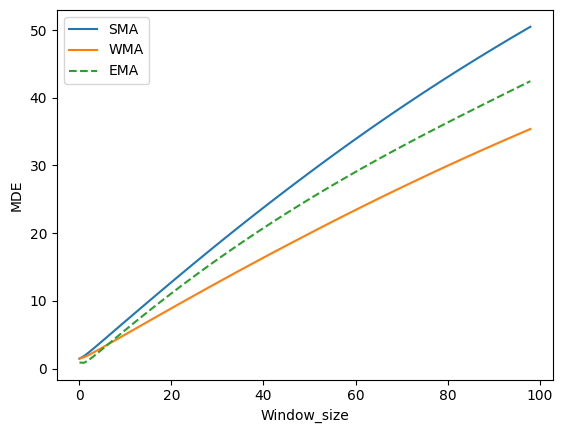

In [18]:
# Plotting the Simple Moving Average (SMA)
plt.plot(mde_sma, label='SMA')

# Plotting the Weighted Moving Average (WMA)
plt.plot(mde_wma, label='WMA')

# Plotting the Exponential Moving Average (EMA)
plt.plot(mde_ema, label='EMA', linestyle='--')
plt.xlabel('Window_size')
plt.ylabel('MDE')
# Adding a legend to the plot
plt.legend()

# Displaying the plot
plt.show()

The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine whether a time series is stationary or non-stationary

Giả thuyết ở đây là: chuỗi thời gian có một đơn vị gốc, nghĩa là nó không ổn định  
Đối thuyết ở đây là: chuỗi thời gian là ổn định, có nghĩa là nó không có đơn vị gốc  
  
Giá trị thống kê được tính bằng kiểm định ADF được so sánh với giá trị phân phối để quyết định có bác bỏ hoặc không bác bỏ giả thuyết. Nếu giá trị thống kê nhỏ hơn giá trị phân phối, giả thuyết sẽ bị bác bỏ và có thể kết luận rằng chuỗi thời gian là ổn định. Nếu giá trị thống kê lớn hơn giá trị phân phối, giả thuyết không thể bị bác bỏ và kết luận rằng chuỗi thời gian là không ổn định.

Chuỗi thời gian ổn định là chuỗi thời gian có các đặc trưng (giá trị trung bình, phương sai) không đổi theo thời gian. Còn chuỗi thời gian không ổn định là chuỗi có các đặc trưng bị thay đổi theo thời gian. Nó thường có xu hướng tăng, hoặc giảm.

In [19]:
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test
result = adfuller(x_raw)

# print test statistic, p-value, and critical values
print(f'Test statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical values:')
for key, value in result[4].items():
    print(f'    {key}: {value}')

Test statistic: -1.8928259490197719
p-value: 0.3354435006495312
Critical values:
    1%: -3.443905150512834
    5%: -2.867517732199813
    10%: -2.569953900520778


Vối mức nghĩa nghĩa 1% - 10% thì test thống kê đều lơn hơn các giá trị kỳ vọng nên giả thuyết không ổn định không thể được bác bỏ.

Do p-value là 0.3354 lớn hơn ngưỡng 0.05, nên ta không đủ bằng chứng để bác bỏ giả thuyết. Nghĩa là chuỗi thời gian của ta không có cố định.

In [20]:
ema_optimizer = pd.read_csv('private_module/history_ema_optimizer_5.csv', header=None, names=['Window', 'Smooth', 'MDE'])
ema_optimizer.head(30)

,Window,Smooth,MDE
0,3.010000,3.0100,0.795599
1,3.019999,3.0200,0.794772
2,3.029996,3.0300,0.793998
3,3.039991,3.0400,0.793274
4,3.049983,3.0500,0.792602
5,3.059971,3.0599,0.791983
6,3.069954,3.0698,0.791412
7,3.079933,3.0797,0.790885
8,3.089906,3.0896,0.790404
9,3.099874,3.0995,0.789966


In [21]:
idx_opt = ema_optimizer['MDE'].idxmin()
opt_row = tuple(ema_optimizer.loc[idx_opt])
print(opt_row)

(6.31205354120125, 5.5819, 0.788037625477903)


Text(0, 0.5, 'MDE')

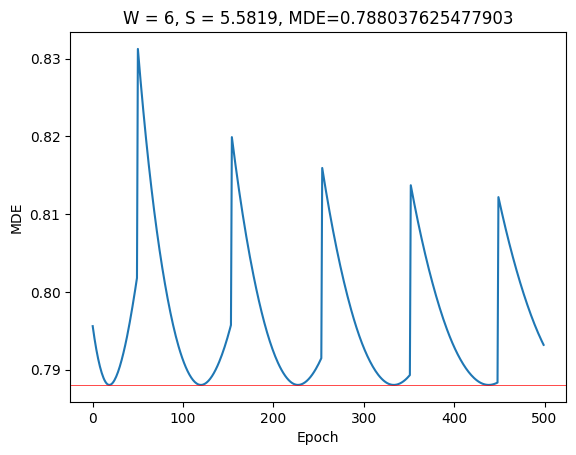

In [22]:
plt.plot(ema_optimizer['MDE'])
plt.axhline(np.min(ema_optimizer['MDE']), color='r', linewidth=0.5)
plt.title(f'W = {round(opt_row[0])}, S = {opt_row[1]}, MDE={opt_row[2]}')
plt.xlabel('Epoch')
plt.ylabel('MDE')

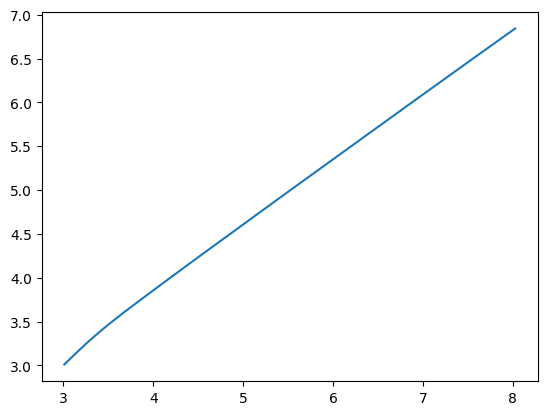

In [23]:
plt.plot(ema_optimizer['Window'], ema_optimizer['Smooth'])
plt.show()